# Distributed Data Parallel (DDP) for Inference

In [ ]:
!pip install transformers accelerate optimum einops tqdm

In [1]:
import json

import torch
import transformers
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
from accelerate.utils import release_memory

### Inference with Pipelines

First let's load and run inference with a `pipeline`

In [2]:
model_id = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             torch_dtype=torch.bfloat16, 
                                             device_map="sequential")

The Falcon model was initialized without `trust_remote_code=True`, and will therefore leverage the transformers library implementation. tiiuae/falcon-7b-instruct's revision is set to a version that doesn't leverage remote code (f8dac3fff96d5debd43edf56fb4e1abcfffbef28).

In order to override this, please set a revision manually or set `trust_remote_code=True`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, dtype: {param.dtype}")

In [4]:
# convert model to bettertransformer to take advantage of Flash Attention
model.to_bettertransformer()

pipe = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


In [5]:
%%timeit -n 2 -r 5
text = "Hello " * 1800
pipe(text, max_new_tokens=100)

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


6.92 s ± 238 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


In [6]:
model = release_memory(model)

### Distributed inference with PartialState

If our model fits on one GPU, we can take advantage of multiple GPU's by keeping a replica on each and distributing our data across them. See [Distributed Inference with Accelerate](https://huggingface.co/docs/accelerate/main/en/usage_guides/distributed_inference) for more details.

In [2]:
%%writefile ddp_inference.py

import json

import torch
import transformers
from tqdm import tqdm
from accelerate import PartialState
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig


def save_dicts_to_jsonl(filename, data_list):
    """
    Saves a list of dictionaries to a JSONL file, where each dictionary is saved as a separate line.

    Args:
    - filename (str): Path to the JSONL file.
    - data_list (list): List of dictionaries to save.
    """
    with open(filename, 'a') as file:
        for data_dict in data_list:
            file.write(json.dumps(data_dict) + '\n')

        
model_id = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             torch_dtype=torch.bfloat16)

# convert model to bettertransformer to take advantage of Flash Attention
model.to_bettertransformer()

distributed_state = PartialState()
model.to(distributed_state.device)

gen_config = GenerationConfig.from_pretrained(model_id, 
                                              max_new_tokens=50, 
                                              do_sample=True, 
                                              pad_token_id=tokenizer.eos_token_id,
                                              eos_token_id=tokenizer.eos_token_id)

prompts = ["Why is distributed inference faster?"]*1000

# Set this value to maximize GPU RAM utilization
# If OOM reduce value, ideally should be multiple of # GPU's
# Note: this isn't batched inference, just batch size to be distributed across GPUs
batch_size = 80

# Calculate the number of batches (taking the ceiling)
n_batches = -(-len(prompts) // batch_size)

for i in tqdm(range(0, len(prompts), batch_size), total=n_batches):
    with distributed_state.split_between_processes(prompts[i:i + batch_size]) as prompt:

        inputs = tokenizer(prompt,
                       return_tensors="pt",
                       return_token_type_ids=False).to("cuda")

        output_ids = model.generate(**inputs, generation_config=gen_config)
        result = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        collect = []
        for text in result:
            collect.append({"text": text, "device":distributed_state.process_index})

        save_dicts_to_jsonl("test_generate.jsonl", collect)

Overwriting ddp_inference.py


#### Run with accelerate

In [3]:
!accelerate launch ddp_inference.py

	`--num_processes` was set to a value of `4`
		More than one GPU was found, enabling multi-GPU training.
		If this was unintended please pass in `--num_processes=1`.
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
The Falcon model was initialized without `trust_remote_code=True`, and will therefore leverage the transformers library implementation. tiiuae/falcon-7b-instruct's revision is set to a version that doesn't leverage remote code (f8dac3fff96d5debd43edf56fb4e1abcfffbef28).

In order to override this, please set a revision manually or set `trust_remote_code=True`.
The Falcon model was initialized without `trust_remote_code=True`, and will therefore leverage the transformers library implementation. tiiuae/falcon-7b-instruct's revision is set to a version that doesn't leverage remote co

### Review results

In [6]:
with open("test_generate.jsonl") as file:
    data = [json.loads(line) for line in file]

In [7]:
df = pd.read_json("test_generate.jsonl", lines=True)

<Axes: xlabel='device'>

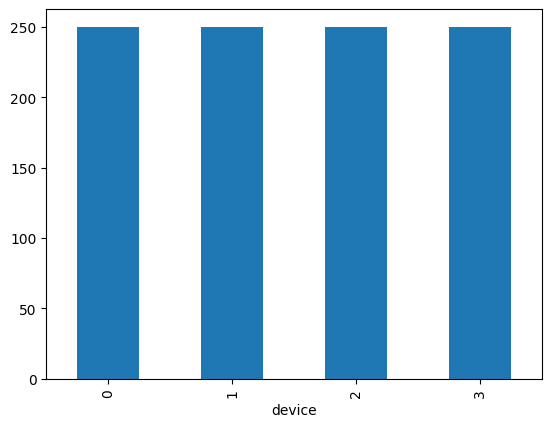

In [8]:
df.groupby("device").size().plot(kind="bar")